## Fitting ppxf to Andes SV data - example notebook

In this notebook we show how to run ppxf on andes SV data, on one spectrum.


Notes:
 * We take as an example the BGS tile 66003.
 * The tile is matched to the truth table to select spectra with reliable redshift measurement.
 * The resolution matrix is converted to a 1D RMS array per pixel in each spectrograph arm, assuming a Gaussian instrumental LOSVD
 * We use templates that have a higher instrumental LOSVD than the DESI data, meaning that we degrade DESI data to the same resolution of the templates. This shouldn't be our working solution, but it serves as an example until we find a higher resolution stellar library from which we can construct suitable templates.
 * The two sets of templates are the same used in the start example notebook, where we fit ppxf to a mock.
 
Ongoing work:
  * investigate effects of noise structure in RMS arrays
  * treat noise properly after convolving the data
  * we need to move to higher resolution stellar library
  * find optimal set of templates - this ties in with parallel project

In [1]:
import sys 
import os 
import h5py 
import numpy as np 
from astropy.io import fits
from astropy.table import Table, join
import pandas as pd
import fitsio

from desitarget.cmx.cmx_targetmask import cmx_mask  
import desispec.io

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
# --- gqp_mc ---
from gqp_mc import util as UT 
from gqp_mc import data as Data 
#from gqp_mc import fitters as Fitters

sys.path.append("/global/homes/r/rtojeiro/desi_gqp/code/")
import desi_gqp_utils as my_utils

import fsps

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import glob
from time import perf_counter as clock

ppxf_dir = os.path.dirname(os.path.realpath(ppxf_package.__file__))
print("ppxf installed here: ", ppxf_dir)

from platform import python_version
print("python version: ", python_version())

ppxf installed here:  /global/u2/r/rtojeiro/mydesi/lib/python3.6/site-packages/ppxf
python version:  3.6.6


### Read truth table

In [2]:
os.environ['TT_DIR']

'/global/cfs/cdirs/desi/sv/vi/TruthTables/'

In [3]:
full_filename = 'truth_table_BGS_v1.2.csv'
df = pd.read_csv(os.environ['TT_DIR']+'/'+full_filename)
#convert from pandas DataFrame to astropy Table for ease later
tt = Table.from_pandas(df)

In [4]:
tt.keys()

['TARGETID',
 'Redrock z',
 'best z',
 'best quality',
 'Redrock spectype',
 'best spectype',
 'all VI issues',
 'all VI comments',
 'merger comment',
 'N_VI',
 'DELTACHI2',
 'ZWARN',
 'ZERR',
 'FIBER',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z']

### Set up directories, etc, to read Andes data

Choose the same tile and night as used for the truth table

In [5]:
%set_env DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux/andes/
%set_env SPECPROD= 

tile = '66003'
date = '20200315'
spectrograph = ['0','1', '2', '3', '4', '5', '6' ,'7', '8', '9']

env: DESI_SPECTRO_REDUX=/global/cfs/cdirs/desi/spectro/redux/andes/
env: SPECPROD=


In [6]:
reduxdir = desispec.io.specprod_root()
print(reduxdir)

/global/cfs/cdirs/desi/spectro/redux/andes/


In [7]:
dirname = os.path.join(os.getenv("DESI_SPECTRO_REDUX"), os.getenv("SPECPROD"), "tiles", tile, date)

filename = "coadd-{}-{}-{}.fits".format(spectrograph[0], tile, date)
specfilename = os.path.join(dirname, filename)
#DM = fitsio.FITS(specfilename)
#DM

### Use desispec io functions to read spectra, fiber map, resolution matrix, etc

https://desispec.readthedocs.io/en/latest/api.html?highlight=read_spectra#desispec-spectra

We can only create a Spectra object per spectrograph because that is how the spectra are organised in SV. In this notebook we will only match one spectrograph to the truth table.

In [8]:
specobj = desispec.io.read_spectra(specfilename)
print('number of spectra read from this spectrograph: ', specobj.num_spectra())

number of spectra read from this spectrograph:  500


Plot a random spectrum and noise

Units are $10^{-17}$ erg/(s cm$^2$ Angstrom)

In [9]:
spectrum = 10

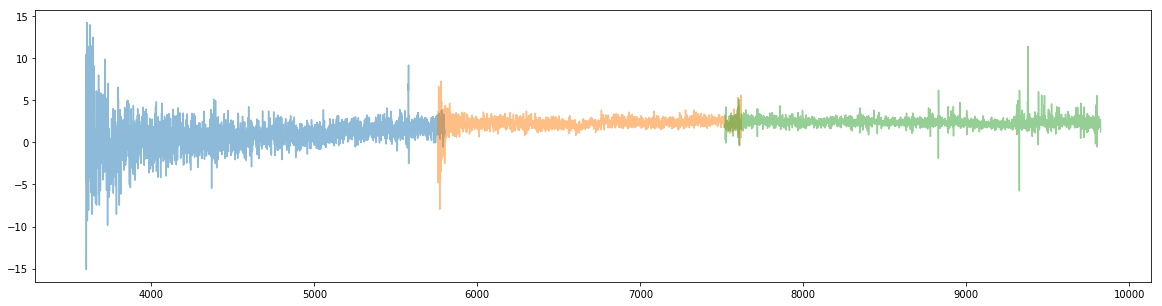

In [10]:
plt.figure(figsize=(20, 5))
#plt.axis([xmin, xmax, ymin, ymax])
plt.plot(specobj.wave["b"], specobj.flux["b"][spectrum], alpha=0.5)
plt.plot(specobj.wave["r"], specobj.flux["r"][spectrum], alpha=0.5)
plt.plot(specobj.wave["z"], specobj.flux["z"][spectrum], alpha=0.5)

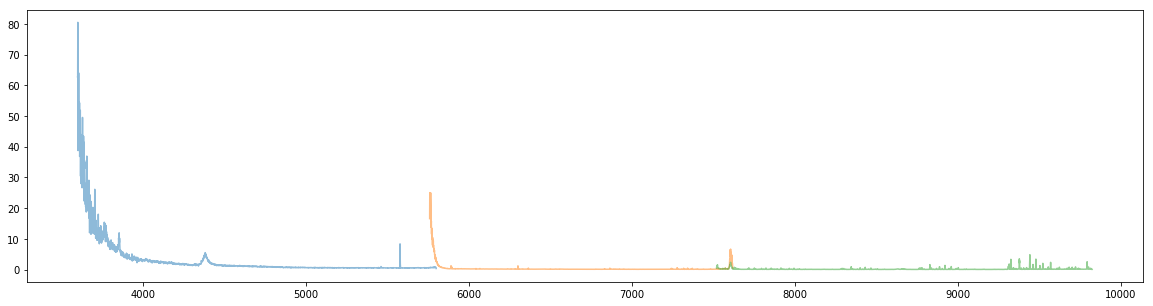

In [11]:
plt.figure(figsize=(20, 5))
#plt.axis([xmin, xmax, ymin, ymax])
plt.plot(specobj.wave["b"], 1./specobj.ivar["b"][spectrum], alpha=0.5)
plt.plot(specobj.wave["r"], 1./specobj.ivar["r"][spectrum], alpha=0.5)
plt.plot(specobj.wave["z"], 1./specobj.ivar["z"][spectrum], alpha=0.5)

Get the full fibermap (it's a Table):

In [12]:
fibermap = specobj.fibermap

Next we will join the fibermap with the truth table:

In [13]:
fibermap = join(fibermap, tt, join_type='left', keys='TARGETID')
print(len(fibermap))

500


Let us select the spectra with high-quality flags, to make sure the redshift is correct.

In [14]:
good = fibermap[fibermap['best quality'].filled(-1) >= 3]['TARGETID', 'best quality']
good_ids = good['TARGETID']
print(len(good_ids))

276


The array good_ids holds the list of targetIDs that we can run through ppxf. We will just choose one at random.

In [15]:
ind = 100
spectrum= np.where(fibermap['TARGETID'] == good_ids[ind])[0][0] #index on fibermap table
redshift = fibermap['best z'][spectrum]
print(spectrum, redshift)

136 0.2014


In [16]:
fibermap['TARGETID'][spectrum]

35191328606258129

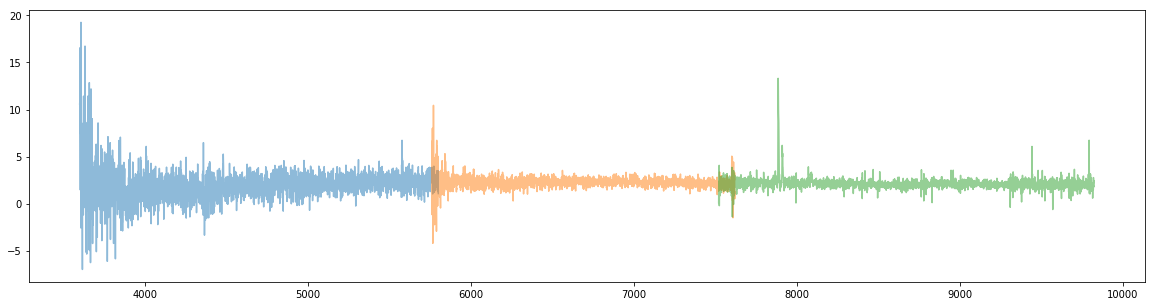

In [17]:
plt.figure(figsize=(20, 5))
#plt.axis([xmin, xmax, ymin, ymax])
plt.plot(specobj.wave["b"], specobj.flux["b"][spectrum], alpha=0.5)
plt.plot(specobj.wave["r"], specobj.flux["r"][spectrum], alpha=0.5)
plt.plot(specobj.wave["z"], specobj.flux["z"][spectrum], alpha=0.5)

Get the wavelength and resolution matrix, and get a 1D vector per arm with the RMS per pixel.

We can, in the future, try to incorporate the full resolution matrix in the analysis, but I don't think there will be great gain in this.

In [18]:
wave_b = specobj.wave["b"] / (1+redshift)
flux_b_lin = specobj.flux["b"][spectrum] / np.median(specobj.flux["b"][spectrum])
noise_b_lin = 1./np.sqrt(specobj.ivar['b'][spectrum]) / np.median(specobj.flux["b"][spectrum])
resdata_b = specobj.resolution_data['b'][spectrum]
RMS_b_lin = my_utils.get_RMS_from_resolution_data(wave_b, resdata_b)# / (1+redshift)

wave_r = specobj.wave["r"] / (1+redshift)
flux_r_lin = specobj.flux["r"][spectrum]/ np.median(specobj.flux["r"][spectrum])
noise_r_lin = 1./np.sqrt(specobj.ivar['r'][spectrum])/ np.median(specobj.flux["r"][spectrum])
resdata_r = specobj.resolution_data['r'][spectrum]
RMS_r_lin = my_utils.get_RMS_from_resolution_data(wave_r, resdata_r)# / (1+redshift)

wave_z = specobj.wave["z"] / (1+redshift)
flux_z_lin = specobj.flux["z"][spectrum]/ np.median(specobj.flux["z"][spectrum])
noise_z_lin = 1./np.sqrt(specobj.ivar['z'][spectrum])/ np.median(specobj.flux["z"][spectrum])
resdata_z = specobj.resolution_data['z'][spectrum]
RMS_z_lin = my_utils.get_RMS_from_resolution_data(wave_z, resdata_z)# / (1+redshift)

Let's see how the RMS per pixel looks like, and compare to the output from desisim

In [19]:
import specsim.config
import specsim.instrument
#load DESI spectrographs configuration
config = specsim.config.load_config('desi')
instrument = specsim.instrument.initialize(config)
    
specsim_wave_blue = instrument.cameras[0]._wavelength 
specsim_rms_blue = instrument.cameras[0].rms_resolution.to(instrument._wavelength.unit).value

specsim_wave_green = instrument.cameras[1]._wavelength 
specsim_rms_green = instrument.cameras[1].rms_resolution.to(instrument._wavelength.unit).value

specsim_wave_red = instrument.cameras[2]._wavelength
specsim_rms_red = instrument.cameras[2].rms_resolution.to(instrument._wavelength.unit).value

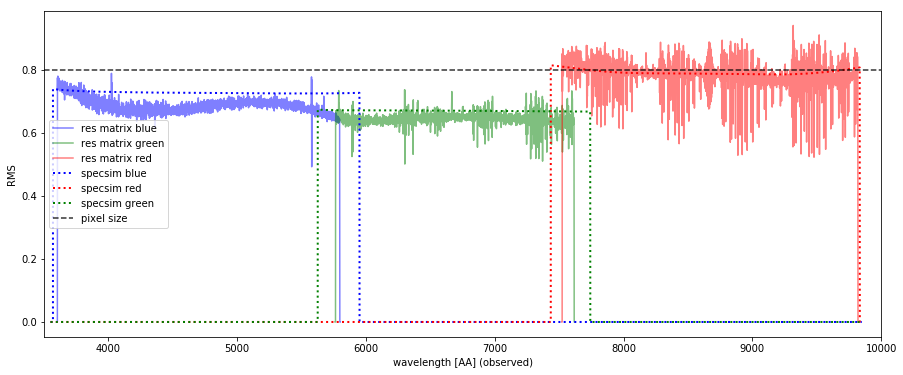

In [20]:
plt.figure(figsize=(15,6))
plt.plot(wave_b*(1+redshift), RMS_b_lin*(1+redshift), color='blue', alpha=0.5, label='res matrix blue')
plt.plot(wave_r*(1+redshift), RMS_r_lin*(1+redshift), color='green', alpha=0.5, label='res matrix green')
plt.plot(wave_z*(1+redshift), RMS_z_lin*(1+redshift), color='red', alpha=0.5, label='res matrix red')
plt.plot(specsim_wave_blue,specsim_rms_blue,color='blue', linestyle='dotted', lw=2, label='specsim blue')
plt.plot(specsim_wave_red,specsim_rms_red,color='red', linestyle='dotted', lw=2, label='specsim red')
plt.plot(specsim_wave_green,specsim_rms_green,color='green', linestyle='dotted', lw=2, label='specsim green')
plt.plot([3500,10000],[0.8, 0.8], color='black', label='pixel size', linestyle='dashed', alpha=0.8)
plt.xlim([3500,10000])
plt.xlabel('wavelength [AA] (observed)')
plt.ylabel('RMS')
plt.legend()

There is more structure here than I'd expect, following the sky lines and other regions where noise increases. From a brief interaction with the data team, this seems to be down to a trade off with uncorrelated noise (or a better behaved noise covariance matrix, I'm not certain) in the spectroperfectionism framework. We ought to explore this somewhat, and see what the difference is recovered LOSVD is when smoothing these out. 

Also note the pixel size is larger than the instrumental LOSVD.

For now, we will carry on just taking these as they are. 

### Preparing the data and templates

We start with the data. 

First, rebin everying into a log lambda grid.

In [21]:
#first, rebin in log_lambda
lamrange_b = [wave_b[0], wave_b[-1]]
flux_b, logLam_b, velscale_b = util.log_rebin(lamrange_b, flux_b_lin)
noise_b, logLam_b, velscale_b = util.log_rebin(lamrange_b, noise_b_lin)
lam_b = np.exp(1)**logLam_b
RMS_b = np.interp(lam_b, wave_b, RMS_b_lin) #interpolate the RMS to the log lambda scale
print('velocity scale b: ', velscale_b)

lamrange_r = [wave_r[0], wave_r[-1]]
flux_r, logLam_r, velscale_r = util.log_rebin(lamrange_r, flux_r_lin)
noise_r, logLam_r, velscale_r = util.log_rebin(lamrange_r, noise_r_lin)
lam_r = np.exp(1)**logLam_r
RMS_r = np.interp(lam_r, wave_r, RMS_r_lin) #interpolate the RMS to the log lambda scale
print('velocity scale r: ', velscale_r)

lamrange_z = [wave_z[0], wave_z[-1]]
flux_z, logLam_z, velscale_z = util.log_rebin(lamrange_z, flux_z_lin)
noise_z, logLam_z, velscale_z = util.log_rebin(lamrange_z, noise_z_lin)
lam_z = np.exp(1)**logLam_z
RMS_r = np.interp(lam_z, wave_z, RMS_z_lin) #interpolate the RMS to the log lambda scale
print('velocity scale z: ', velscale_z)


velocity scale b:  [51.99281229]
velocity scale r:  [36.08346799]
velocity scale z:  [27.82067165]


From here on, we'll just work on the blue arm. Everything is identical for the other two.

In [22]:
c = 299792.458                  # speed of light in km/s
frac = lam_b[1]/lam_b[0]    # Constant lambda fraction per pixel
dlam_b = (frac - 1)*lam_b   # Size of every pixel in Angstrom
fwhm_b = 2.355*RMS_b # Resolution FWHM of every pixel, in Angstroms
velscale = np.log(frac)*c       # Velocity scale in km/s per pixel (eq.8 of Cappellari 2017)
print('velocity scale (should match above): ', velscale)
#print('wavelength range: ', lam_b[0], lam_b[-1])

velocity scale (should match above):  51.992812288188695


Now we'll read the templates. The read_simple_templates routine will return them on the same wavelength range and log lambda grid as the data.

In [23]:
import imp
imp.reload(my_utils)

<module 'desi_gqp_utils' from '/global/homes/r/rtojeiro/desi_gqp/code/desi_gqp_utils.py'>

In [24]:
fwhm_temp = 3.0 #resolution of the Stelib library is around 3AA

full model wavelength range:  2996.4309569543643 4827.61531712636
requested model wavelength range: [2996.4309569543643, 4827.61531712636]
[51.99281229] [51.99281229]
[51.99281229] [51.99281229]
[3400.0, 4827.61531712636]
wavelength range returned: 3400.5770796096285 4827.2282484920515
(2021, 2)


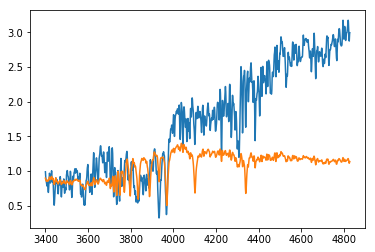

In [25]:
#load simple disk + bulge models
#Units of the disk + bulge templates are W/AA.

imp.reload(my_utils)
(loglam_temp, templates_simple, norm) = my_utils.read_simple_templates(velscale_b,[lam_b[0], lam_b[-1]])
lam_temp = np.exp(1)**loglam_temp
print('wavelength range returned:', lam_temp[0], lam_temp[-1])
print(np.shape(templates_simple))

[2996.4309569543643, 4827.61531712636]
[3400.0, 4827.61531712636]
(2021, 6)


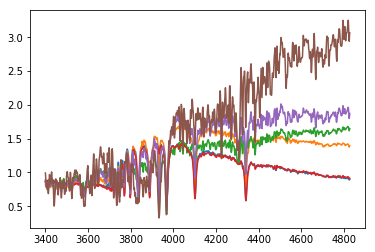

In [26]:
#load set of SSPs
#Units of the SSP templates are L_solar/AA.

imp.reload(my_utils)
ages = np.array([0.1, 1, 10]) #in Gyrs
Z = np.array([0.001, 0.02])#metallicity between 0.0001 and 0.05 (fraction of metals by mass, Z_solar~0.02)

loglam_temp_ssp, templates_ssp = my_utils.make_ssp_templates_bc03(velscale_b,[lam_b[0], lam_b[-1]], ages, Z)

print(np.shape(templates_ssp))

In [27]:
print([lam_b[0], lam_b[-1]])

[2996.4309569543643, 4827.61531712636]


Check whether models cover the full wavelenth range. If not, reduce the data accordingly.

In [28]:
if lam_b[0] != lam_temp[0]:
    print('reducing wavelength range')
    mask = (lam_b > lam_temp[0])
    lam_b=lam_b[mask]
    flux_b = flux_b[mask]
    noise_b = noise_b[mask]
    fwhm_b = fwhm_b[mask]
    dlam_b = dlam_b[mask]
print(len(flux_b))

reducing wavelength range
2021


In [29]:
dv = c*np.log(lam_temp[0]/lam_b[0])    # eq.(8) of Cappellari (2017)
print(dv)
goodpixels = util.determine_goodpixels(np.log(lam_b), lamrange_b, redshift) #exclude emission line regions

-24.0377291605112


Define kernel to degrade data to the template resolution, and perform the convolution. ppxf's gaussian_filter1d is fast and will work with a variable sigma with wavelength

In [30]:
fwhm_diff = np.sqrt((fwhm_temp**2 - fwhm_b**2).clip(0)) #kernel to apply to data - IDEALLY THIS WOULD BE THE OTHER WAY AROUND!
sigma = fwhm_diff/2.355/dlam_b # Sigma difference in pixels

In [31]:
flux_b_conv = util.gaussian_filter1d(flux_b, sigma)
noise_b_conv = noise_b / (2*sigma*np.sqrt(np.pi)) #assuming gaussian noise
print(len(flux_b_conv))

2021


Plot spectra to make sure things look OK

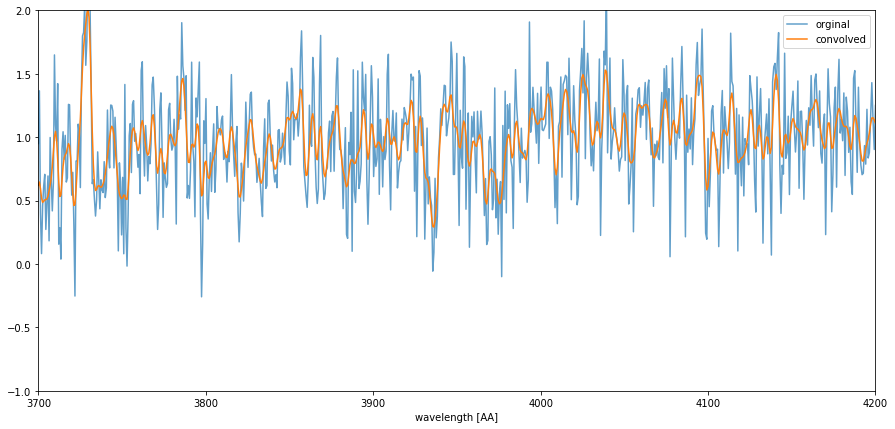

In [32]:
plt.figure(figsize=(15,7))
plt.plot(lam_b, flux_b, label='orginal', alpha=0.7)
plt.plot(lam_b, flux_b_conv, label='convolved')
plt.xlim(3700, 4200)
plt.xlabel('wavelength [AA]')
plt.ylim(-1,2)
plt.legend()

## ppxf fits

In [33]:
# Here the actual fit starts. The best fit is plotted on the screen.
# Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
#
vel = 0.0 #c*np.log(1 + redshift)   # eq.(8) of Cappellari (2017)
start = [vel, 200.]  # (km/s), starting guess for [V, sigma]
t = clock()

Fit with the simple bulge and disk templates:

Best Fit:       Vel     sigma
 comp. 0:        29       196
chi2/DOF: 7.186
method = capfit; Jac calls: 4; Func calls: 16; Status: 2
Nonzero (>0.1%) Templates: 2 / 2
Templates weights:
     0.084     0.553
Formal errors:
     dV    dsigma   dh3      dh4
      29      41
Elapsed time in PPXF: 0.07 s
VI/RR z: 0.20151709357043024
Best-fitting redshift: 0.20151709357043024


Text(0.5,1,'bulge + disk template fit')

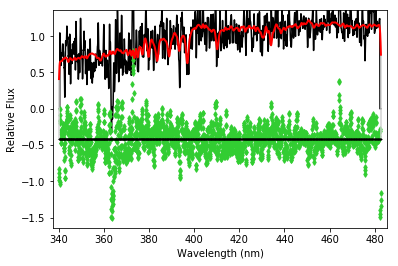

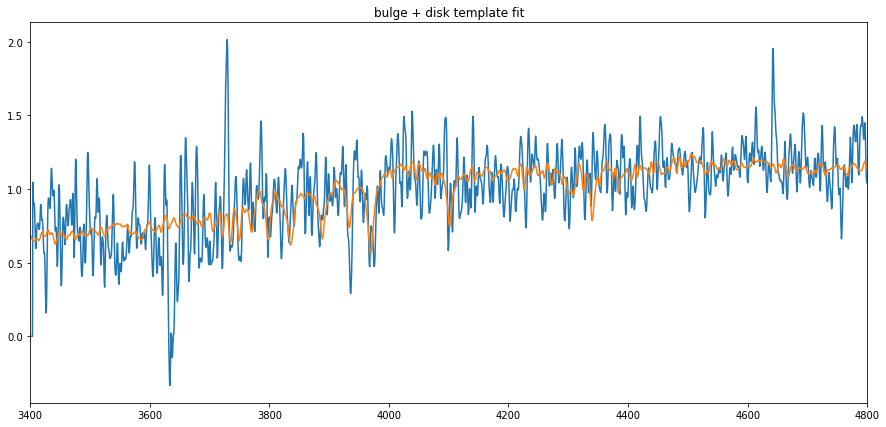

In [34]:
pp = ppxf(templates_simple, flux_b_conv,noise_b_conv, velscale_b, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_b)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))

print('VI/RR z:', (redshift + 1)*(1 + pp.sol[0]/c) - 1)
print('Best-fitting redshift:', (redshift + 1)*(1 + pp.sol[0]/c) - 1)

bestfit = templates_simple @ pp.weights + pp.apoly

plt.figure(figsize=(15,7))

plt.xlim(3400, 4800)
plt.plot(lam_b, flux_b_conv)
plt.plot(lam_b, bestfit)
plt.title('bulge + disk template fit')

Fit with 6 SSP templates

Best Fit:       Vel     sigma
 comp. 0:       -19       233
chi2/DOF: 0.206
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
Nonzero (>0.1%) Templates: 3 / 6
Templates weights:
     0.318  4.95e-16     0.371 -6.55e-15 -6.94e-17    0.0499
Formal errors:
     dV    dsigma   dh3      dh4
      27      37
Elapsed time in PPXF: 0.44 s
VI/RR z: 0.20132458866247238
Best-fitting redshift: 0.20132458866247238


Text(0.5,1,'6 SSP templates fit')

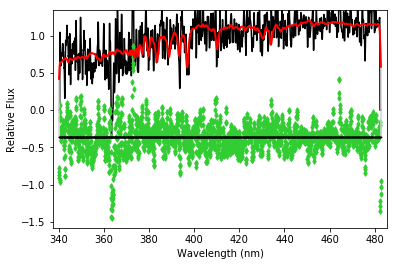

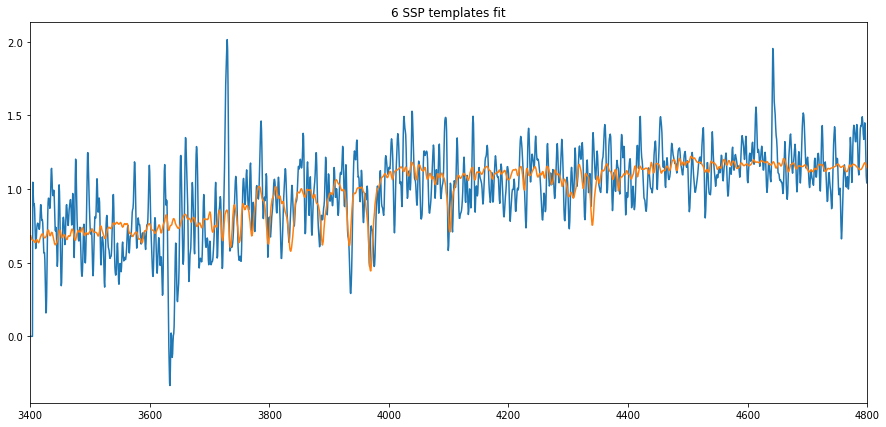

In [35]:
pp = ppxf(templates_ssp, flux_b_conv,noise_b, velscale_b, start,plot=True, \
          moments=2, degree=4, vsyst=dv, clean=False, lam=lam_b)

print("Formal errors:")
print("     dV    dsigma   dh3      dh4")
print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

print('Elapsed time in PPXF: %.2f s' % (clock() - t))

print('VI/RR z:', (redshift + 1)*(1 + pp.sol[0]/c) - 1)
print('Best-fitting redshift:', (redshift + 1)*(1 + pp.sol[0]/c) - 1)

bestfit = templates_ssp @ pp.weights + pp.apoly

plt.figure(figsize=(15,7))

plt.xlim(3400, 4800)
plt.plot(lam_b, flux_b_conv)
plt.plot(lam_b, bestfit)
plt.title('6 SSP templates fit')